# Bike Rental in Washington, D.C.

###### The aim of the project is to predict the number of bike rented in a given hour, provided different parameters.
###### The data set was comiled by [Hadi Fanaee-T](https://folk.uio.no/hadift/) in CSV format
###### Dataset can be downloaded from [University of California, Irvine's website](http://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset)

In [44]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import time
%matplotlib inline

In [45]:
bike_rental = pd.read_csv('bike_rental_hour.csv')
bike_rental.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


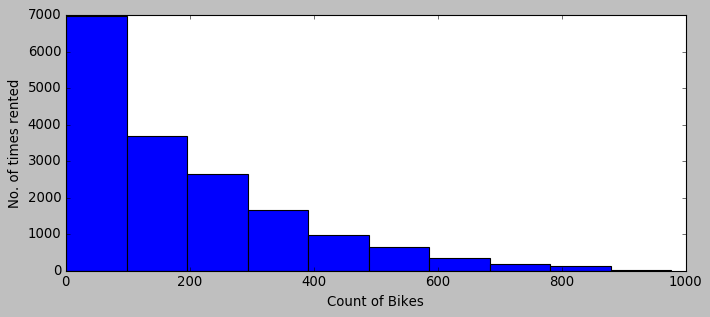

In [46]:
plt.style.use('classic')
fig = plt.figure(figsize=(10,4))
plt.hist(bike_rental['cnt'])
plt.xlabel('Count of Bikes')
plt.ylabel('No. of times rented');

In [47]:
# Dropping columns: "instant(no actual meaning), casual and registered(information leak)".
bike_rental = bike_rental.drop(columns=['instant','registered','casual'])

In [48]:
# Let's check how much different columns are correlated with our target 'cnt' column
bike_rental.corr()['cnt'].abs().sort_values(ascending=False)

cnt           1.000000
temp          0.404772
atemp         0.400929
hr            0.394071
hum           0.322911
yr            0.250495
season        0.178056
weathersit    0.142426
mnth          0.120638
windspeed     0.093234
holiday       0.030927
workingday    0.030284
weekday       0.026900
Name: cnt, dtype: float64

Above correlation shows that "temperature, feeling temperature, hour of the day, humidity" are few of the top factors affecting the rental. We have not considered "registered, casual" because they leak the information. Also "instant" is just unique value for each row which doesnot have any actual meaning.

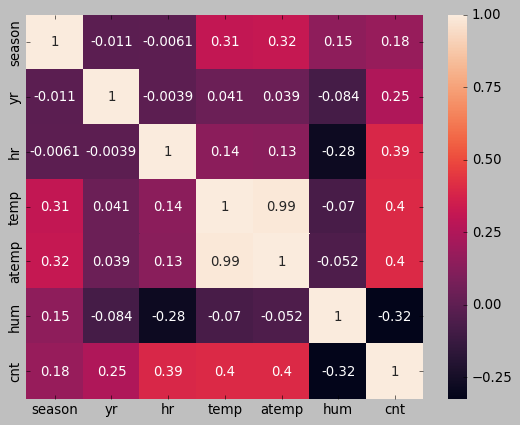

In [49]:
sorted_corrs = bike_rental.corr()['cnt'].abs()>0.17
strong_corrs = sorted_corrs[sorted_corrs]
corrmat = bike_rental[strong_corrs.index].corr()
sns.heatmap(corrmat,annot=True);

In [50]:
# Let's bundle similar times together, enabling the model to make better prediction
def assign_label(x):
    if 6 <= x < 12:
        return 1
    elif 12 <= x < 18:
        return 2
    elif 18 <= x < 24:
        return 3
    elif 0 <= x < 6:
        return 4

# Creating new column 'time_label' using 'assign_label' function    
bike_rental['time_label'] = bike_rental['hr'].apply(lambda x : assign_label(x))

### Error Metrics

Since we have numeric continuous data, Mean Squared Error will fit the most for evaluating performance of mode.

In [51]:
# Splitting the data set into train and test, with train containing
# 80% of the entire dataset
train = bike_rental.sample(frac=0.8)
test = bike_rental.loc[~bike_rental.index.isin(train.index)]

In [52]:
# Not including 'atemp' in features list, as the above heatmap shows that temp and atemp are correlated
features = ['season', 'yr', 'mnth', 'hr', 'holiday', 'weekday','workingday', 'weathersit', 'temp', 'hum', 'windspeed','time_label']
label = ['cnt']

from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(train[features], train[label])
predictions = lr.predict(test[features])
predictions

array([[-123.16057375],
       [-113.45304653],
       [ 133.69388462],
       ...,
       [ 171.89310124],
       [ 159.69312231],
       [ 183.97848553]])

In [53]:
# Let's calculate the MSE
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(test[label], predictions)
mse

16937.50494918122

### Error

The error is high because of the fact that there are few cnt values which are extermely high. Large errors are penalized more with MSE.

In [55]:
start_time = time.time()
from sklearn.tree import DecisionTreeRegressor
dtr = DecisionTreeRegressor(min_samples_leaf=2, random_state=1, max_depth=13)
dtr.fit(train[features], train[label])
dtr_predictions = dtr.predict(test[features])
mse_dtr = mean_squared_error(test[label], dtr_predictions)
print('Total time taken:',time.time()-start_time,'seconds')
mse_dtr

Total time taken: 0.05699300765991211 seconds


3082.74362230317

### Decision Tree Error

The mse from decision tree using min_samples_leaf=2 and max_depth=13 is 3134.58 which is much lower than what we received from Linear Regression model

In [56]:
start_time = time.time()
from sklearn.ensemble import RandomForestRegressor
rfr = RandomForestRegressor(n_estimators=170,random_state=1,max_depth=35)
rfr.fit(train[features], train[label])
rfr_predictions = rfr.predict(test[features])
mse_rfr = mean_squared_error(test[label], rfr_predictions)
print('Total time taken:',time.time()-start_time,'seconds')
mse_rfr

/Users/alok/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  after removing the cwd from sys.path.


Total time taken: 7.0636887550354 seconds


1829.6948642797663

### Random Forest Error

By using Random forest we can see that the accuracy has been improved in comparision to what we got from Decision Tree.